## Import the required Libraries

In [1]:
from nltk.corpus import stopwords
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import SGDClassifier, LogisticRegression
import numpy as np
from nltk.corpus import reuters 
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
import timeit
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
from gensim.models import Phrases
from gensim.corpora import Dictionary
stop_words = set(stopwords.words('english'))
p_stemmer = PorterStemmer()
tokenizer = RegexpTokenizer(r'\w+')

unable to import 'smart_open.gcs', disabling that module


## Reading the given data

In [2]:
import pandas as pd
trials_data = pd.read_csv("us_trial.text", sep="/t,/n", header = None)
trials_data.columns = ['original_text']
print(trials_data)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


                                           original_text
0      A little throwback with my favourite person @ ...
1      glam on @user yesterday for #kcon makeup using...
2      Democracy Plaza in the wake of a stunning outc...
3       Then &amp; Now. VILO @ Walt Disney Magic Kingdom
4                   Who never... @ A Galaxy Far Far Away
...                                                  ...
49995  My #O2otd Love this chain so much and our new ...
49996  Met Santa and Olaf @ the North Pole today @ No...
49997  New York by Night Strideby #HERElocationNYC......
49998  Kisses for the birthday girl! @ Helzberg Diamonds
49999  Dinner with this priceless view!Thank you, S #...

[50000 rows x 1 columns]


In [3]:
trials_data['labels'] = pd.read_csv("us_trial.labels", sep="\t", header = None)


There are 50,000 records and corresponding labels, let's check the number of unique values in the target variable

## Check the number of unique values in the target variable

In [4]:
trials_data['labels'].unique()

array([ 0,  7, 11,  2,  1,  8, 13,  9, 16, 19,  4,  6, 14,  5, 10, 15,  3,
       12, 17, 18], dtype=int64)

There are 20 unique labels, let's check the value count for each label

In [5]:
trials_data['labels'].value_counts()

0     10760
1      5279
2      5241
3      2885
4      2517
5      2317
6      2049
7      1894
8      1796
9      1671
10     1544
11     1528
12     1462
14     1377
13     1346
16     1306
18     1286
17     1279
15     1249
19     1214
Name: labels, dtype: int64

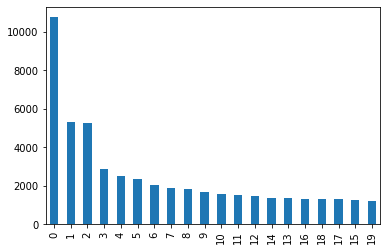

In [6]:
trials_data['labels'].value_counts().plot.bar(x='lab', y='val')

### Creating training and test sets

We'll be using 80% of the tweets (for each profile) for training and 20% for testing, i.e. a 80-20 split as mentioned in [this](http://snap.stanford.edu/soma2010/papers/soma2010_12.pdf) paper by Davison et al. Cross validation can and should be done.

In [7]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(trials_data['original_text'], trials_data['labels'],
                                                    stratify=trials_data['labels'], 
                                                    test_size=0.20)

## Function to word_transform (convert into lower case, split and remove stop words)

In [8]:
def word_transform(doc_set, ldamodel, dictionary,no_topics):
    data = []
    # loop through document list
    for i in doc_set:
        doc = ' '.join([word for word in i.split() if word not in stop_words])
        doc = doc.lower()
        doc = doc.split()
        #print(doc_lda)
        doc_prob = [0] * no_topics
        for j in doc:
            if j in stop_words:
                continue
            word_dist = ldamodel.get_document_topics(dictionary.doc2bow(list(j)))#ldamodel[dictionary.doc2bow(list(j))]
            for k in word_dist: 
                doc_prob[int(k[0])] = doc_prob[int(k[0])] + float(k[1])
        data.append(doc_prob )
        #print(doc_prob)
    return data

## Function to topic_transform (convert into lower case, split and remove stop words)

In [9]:
def topic_transform(doc_set, ldamodel, dictionary,no_topics):
    data = []
    # loop through document list
    for i in doc_set:
        doc = ' '.join([word for word in i.split() if word not in stop_words])
        doc = doc.lower()
        doc_lda = ldamodel[dictionary.doc2bow(tokenizer.tokenize(doc))]
        #print(doc_lda)
        doc_prob = [0] * no_topics
        for j in doc_lda:
            doc_prob[int(j[0])] = float(j[1])
        data.append(doc_prob)
        #print(doc_prob)
    return data

## Function to tokenize the document

In [10]:
def tokenize(doc_set):
    # list for tokenized documents in loop
    texts = []
    tokenizer = RegexpTokenizer(r'\w+')
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)

        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in stop_words]

        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

## Code to create corpus from our document

In [11]:
def create_corpus(doc_set):
    texts = tokenize(doc_set)
    # turn our tokenized documents into a id <-> term dictionary
    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=10, no_above=0.5)
    # convert tokenized documents into a document-term matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    return dictionary, corpus

## Function to load Glove Data

In [12]:
def load_glove_data():
    # read the word to vec file
    GLOVE_6B_100D_PATH = "glove.6B.100d.txt"
    dim = 100
    glove_small = {}
    with open(GLOVE_6B_100D_PATH, "rb") as infile:
        for line in infile:
            parts = line.split()
            try:
                word = parts[0].decode("utf-8")
                x = []
                for i in range(len(parts)-1):
                    x.append(float(parts[i+1].decode("utf-8")))
                glove_small[word] = x
            except: 
                print('')
    return glove_small

## Function for word2vec Transformation (glove 100d for this use case)

In [13]:
def word2vec_transform(dataset, word2vec, dim):
    trans_data = []
    for doc in dataset:
        words = doc.lower().split()
        w_length = 1
        data = np.zeros(dim)
        for i in range(len(words)):
            if words[i] in word2vec and words[i] not in stop_words:
                data = data + word2vec[words[i]]
                w_length = w_length + 1
        data = data / float(w_length)
        trans_data.append(data)
    return trans_data

## Try different models on Count Vectorized Train data

In [14]:
def tf_classify(train_docs, train_labels, test_docs, test_labels):
    text_clf = Pipeline([('vect', CountVectorizer()), ('clf',LogisticRegression()) ])
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    print("tf_LogisticReg    " + str(100 * np.mean(predicted == test_labels)))
    
    text_clf = Pipeline([('vect', CountVectorizer()), ('clf',MultinomialNB()) ])
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    print("tf_MultiNaiveBayes    " + str(100 * np.mean(predicted == test_labels)))
    
    text_clf = Pipeline([('vect', CountVectorizer()), ('clf',KNeighborsClassifier(n_neighbors=3)) ])
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    print("tf_KNN    " + str(100 * np.mean(predicted == test_labels)))
    
    text_clf = Pipeline([('vect', CountVectorizer()), ('clf', SGDClassifier(random_state=42, tol=.001)), ])
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    print("tf_sgd    " + str(100 * np.mean(predicted == test_labels)))

## Try different models on TFIDF Train data

In [15]:
def tf_idf_classify(train_docs, train_labels, test_docs, test_labels):
    text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf',LogisticRegression()) ])
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    print("tf_idf_LogisticReg    " + str(100 * np.mean(predicted == test_labels)) )
    
    text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf',MultinomialNB()) ])
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    print("tf_idf_MultiNaiveBayes    " + str(100 * np.mean(predicted == test_labels)) )
    
    text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf',KNeighborsClassifier(n_neighbors=3)) ])
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    print("tf_idf_KNN    " + str(100 * np.mean(predicted == test_labels)) )
    
    text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SGDClassifier(random_state=42, tol=.001)), ])
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    print("tf_idf_sgd    " + str(100 * np.mean(predicted == test_labels))  )

## Try different models on Glove Transformed Train data

In [16]:
def word2vec_classify(train_docs, train_labels, test_docs, test_labels):
    word2vec = load_glove_data()
    train_docs = word2vec_transform(train_docs, word2vec, 100)
    test_docs = word2vec_transform(test_docs, word2vec, 100)
    
    text_clf = LogisticRegression()
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    print("word2vec_tf_LogisticReg    " + str(100 * np.mean(predicted == test_labels)))
    
    #text_clf = MultinomialNB()
    #text_clf.fit(train_docs, train_labels) 
    #predicted = text_clf.predict(test_docs)
    #print("word2vec_tf_MultiNaiveBayes    " + str(100 * np.mean(predicted == test_labels)))
    
    text_clf = KNeighborsClassifier(n_neighbors=3)
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    print("word2vec_KNN    " + str(100 * np.mean(predicted == test_labels)))
    
    sgd = SGDClassifier(random_state=420, tol=.001)#MultinomialNB()
    sgd.fit(train_docs, train_labels)  
    predicted = sgd.predict(test_docs)
    print("word2vec_sgd    " + str(100 * np.mean(predicted == test_labels))  )

## Try different models on Glove Transformed and LDA

In [17]:
def LDA_classify(train_docs, train_labels, test_docs, test_labels):
    text_clf = LogisticRegression()
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    Log_accu = 100 * np.mean(predicted == test_labels)
    print("LDA_LogisticReg " + str(Log_accu))
    
    #text_clf = MultinomialNB()
    #text_clf.fit(train_docs, train_labels) 
    #predicted = text_clf.predict(test_docs)
    #NB_accu = 100 * np.mean(predicted == test_labels)
    #print("LDA_MultiNB     " + NB_accu)
    
    text_clf = KNeighborsClassifier(n_neighbors=3)
    text_clf.fit(train_docs, train_labels) 
    predicted = text_clf.predict(test_docs)
    KNN_accu = 100 * np.mean(predicted == test_labels)
    print("LDA_KNN     " + str(KNN_accu))
    
    sgd = SGDClassifier(random_state=420, tol=.001)#MultinomialNB()
    sgd.fit(train_docs, train_labels)  
    predicted = sgd.predict(test_docs)
    sgd_accu = 100 * np.mean(predicted == test_labels)
    print("LDA_sgd     " + str(sgd_accu))
    return Log_accu,KNN_accu,sgd_accu

## Build your models on train data and test and test data

In [18]:
tf_classify(train_data, train_labels, test_data, test_labels)
tf_idf_classify(train_data, train_labels, test_data, test_labels)
word2vec_classify(train_data, train_labels, test_data, test_labels)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


tf_LogisticReg    28.98
tf_MultiNaiveBayes    26.83
tf_KNN    18.85
tf_sgd    28.09


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


tf_idf_LogisticReg    30.89
tf_idf_MultiNaiveBayes    23.14
tf_idf_KNN    20.1
tf_idf_sgd    28.050000000000004


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


word2vec_tf_LogisticReg    27.26
word2vec_KNN    20.11
word2vec_sgd    16.57


In [19]:
no_topics = [5, 10, 15, 20, 25, 30, 35, 40]
dictionary, corpus = create_corpus(str(train_data) + str(test_data))
time = np.zeros(len(no_topics))

topics_accu_Log = np.zeros(len(no_topics))
#topics_accu_MNB = np.zeros(len(no_topics))
topics_accu_KNN = np.zeros(len(no_topics))
topics_accu_sgd = np.zeros(len(no_topics))

words_accu_Log = np.zeros(len(no_topics))
#words_accu_MNB = np.zeros(len(no_topics))
words_accu_KNN = np.zeros(len(no_topics))
words_accu_sgd = np.zeros(len(no_topics))

In [20]:
for i in range(len(no_topics)):
    # train LDA model
    start = timeit.default_timer()
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=no_topics[i], id2word = dictionary, passes=30)
    end = timeit.default_timer()
    time[i] = end - start
    print(time[i])
    
    # get data represented as a distribution over the topics
    test_docs = topic_transform(test_data, ldamodel, dictionary,no_topics[i])
    train_docs = topic_transform(train_data, ldamodel, dictionary,no_topics[i])
    topics_accu_Log[i], topics_accu_KNN[i], topics_accu_sgd[i] =  LDA_classify(train_docs, train_labels, test_docs, test_labels)
    
    test_docs = word_transform(test_data, ldamodel, dictionary,no_topics[i])
    train_docs = word_transform(train_data, ldamodel, dictionary,no_topics[i])
    words_accu_Log[i], words_accu_KNN[i], words_accu_sgd[i] =  LDA_classify(train_docs, train_labels, test_docs, test_labels)

24.88611739999999
LDA_LogisticReg 21.52
LDA_KNN     21.02
LDA_sgd     21.060000000000002


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.51
LDA_KNN     15.329999999999998
LDA_sgd     5.7299999999999995
24.13413509999998


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.52
LDA_KNN     10.79
LDA_sgd     3.1199999999999997


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.37
LDA_KNN     15.229999999999999
LDA_sgd     21.54
26.06492359999993


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.52
LDA_KNN     21.08
LDA_sgd     2.6


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.5
LDA_KNN     15.45
LDA_sgd     9.92
29.158257100000128


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.52
LDA_KNN     21.15
LDA_sgd     2.8000000000000003


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.34
LDA_KNN     15.39
LDA_sgd     8.83
27.872921099999985


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.52
LDA_KNN     20.87
LDA_sgd     2.83


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.43
LDA_KNN     15.129999999999999
LDA_sgd     14.66
30.935923800000182


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.52
LDA_KNN     20.830000000000002
LDA_sgd     2.68


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.37
LDA_KNN     15.57
LDA_sgd     13.87
33.42821779999986


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.529999999999998
LDA_KNN     20.95
LDA_sgd     2.6599999999999997


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.4
LDA_KNN     15.76
LDA_sgd     14.01
8.828369100000145


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.529999999999998
LDA_KNN     4.12
LDA_sgd     2.77


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LDA_LogisticReg 21.42
LDA_KNN     15.310000000000002
LDA_sgd     11.27


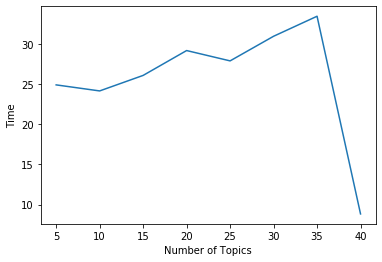

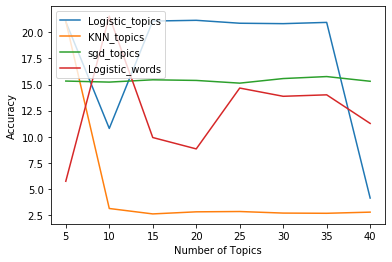

In [21]:
plt.figure(1)
plt.plot(no_topics, time)
plt.xlabel('Number of Topics')
plt.ylabel('Time')

plt.figure(2)
plt.plot(no_topics, topics_accu_KNN)
plt.plot(no_topics, topics_accu_sgd)
plt.plot(no_topics, words_accu_KNN)
plt.plot(no_topics, words_accu_sgd)
plt.xlabel('Number of Topics')
plt.ylabel('Accuracy')
plt.legend(['Logistic_topics','KNN_topics', 'sgd_topics', 'Logistic_words', 'KNN_words', 'sgd_words'], loc='upper left')
plt.show()

#### Using Logistic Regression, we are able to achieve 21.5% accuracy, the ideal number of topics seem to be 15-35

## Let us build Neural Network Models to improve our accuracy

Let us build these 3 ML models on TF, TFIDF and word2vec train data

In [ ]:
# Import the required libraries 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import pandas as pd
import json


# Feature Engineering 
print ("CountVectorizer on text data ... ")
tfidf = CountVectorizer(max_features=3010)
X = tfidf.fit_transform(train_data).astype('float32')
X_test = tfidf.transform(test_data).astype('float32')

# Label Encoding - Target 
print ("Label Encode the Target Variable ... ")
lb = LabelEncoder()
y = lb.fit_transform(train_labels)
dummy_y_train = np_utils.to_categorical(y)

In [128]:
# Model Training 
print ("Create model ... ")
def build_model():
    model = Sequential()
    model.add(Dense(256, input_dim=3010, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(20, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

print("Compile model ...")
estimator = KerasClassifier(build_fn=build_model, epochs=25, batch_size=64)
estimator.fit(X, dummy_y_train)

TF-IDF on text data ... 
Label Encode the Target Variable ... 
Create model ... 
Compile model ...
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 256)               770816    
_________________________________________________________________
dropout_136 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_166 (Dense)            (None, 200)               51400     
_________________________________________________________________
dropout_137 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_167 (Dense)            (None, 160)               32160     
_________________________________________________________________
dropout_138 (Dropout)        (None, 160)               0         
____________________

In [129]:
# Predictions 
print ("Predict on test data ... ")
y_test = estimator.predict(X_test)
y_pred = lb.inverse_transform(y_test)

y_test_train = estimator.predict(X)
y_pred_train = lb.inverse_transform(y_test_train)

print("tfidf_ann train accuracy   " + str(100 * np.mean(y_pred_train == train_labels)))
print("tfidf_ann test accuracy   " + str(100 * np.mean(y_pred == test_labels)))

Predict on test data ... 
tfidf_ann train accuracy   86.08749999999999
tfidf_ann test accuracy   22.35


## TFIDF Followed by ANN

In [137]:
# Feature Engineering 
print ("TF-IDF on text data ... ")
tfidf = TfidfVectorizer(binary=True, max_features=3010)
X = tfidf.fit_transform(train_data).astype('float32')
X_test = tfidf.transform(test_data).astype('float32')

TF-IDF on text data ... 


In [ ]:
print("Compile model ...")
estimator = KerasClassifier(build_fn=build_model, epochs=25, batch_size=64)
estimator.fit(X, dummy_y_train)

In [127]:
# Predictions 
print ("Predict on test data ... ")
y_test = estimator.predict(X_test)
y_pred = lb.inverse_transform(y_test)

y_test_train = estimator.predict(X)
y_pred_train = lb.inverse_transform(y_test_train)

print("tfidf_ann train accuracy   " + str(100 * np.mean(y_pred_train == train_labels)))
print("tfidf_ann test accuracy   " + str(100 * np.mean(y_pred == test_labels)))

Predict on test data ... 
tfidf_ann train accuracy   87.99249999999999
tfidf_ann test accuracy   21.23


## Word2vec Followed by ANN

In [140]:
# Feature Engineering 
print ("Word2Vec on text data ... ")
tfidf = TfidfVectorizer(binary=True, max_features=3010)
X = tfidf.fit_transform(train_data).astype('float32')
X_test = tfidf.transform(test_data).astype('float32')

word2vec = load_glove_data()
X = word2vec_transform(train_data, word2vec, 100)
X_test = word2vec_transform(test_data, word2vec, 100)

Word2Vec on text data ... 


In [146]:
X_train = np.array(X)
X_train.shape

(40000, 100)

In [148]:
# Model Training 
print ("Create model ... ")
def build_model():
    model = Sequential()
    model.add(Dense(256, input_dim=100, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(200, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(160, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(120, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(20, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model


print("Compile model ...")
estimator = KerasClassifier(build_fn=build_model, epochs=25, batch_size=64)
estimator.fit(X_train, dummy_y_train)

Create model ... 
Compile model ...
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_195 (Dense)            (None, 256)               25856     
_________________________________________________________________
dropout_161 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_196 (Dense)            (None, 200)               51400     
_________________________________________________________________
dropout_162 (Dropout)        (None, 200)               0         
_________________________________________________________________
dense_197 (Dense)            (None, 160)               32160     
_________________________________________________________________
dropout_163 (Dropout)        (None, 160)               0         
_________________________________________________________________
dense_198 (Dense)

In [150]:
# Predictions 
print ("Predict on test data ... ")
y_test = estimator.predict(np.array(X_test))
y_pred = lb.inverse_transform(y_test)

y_test_train = estimator.predict(X_train)
y_pred_train = lb.inverse_transform(y_test_train)

print("tfidf_ann train accuracy   " + str(100 * np.mean(y_pred_train == train_labels)))
print("tfidf_ann test accuracy   " + str(100 * np.mean(y_pred == test_labels)))

Predict on test data ... 
tfidf_ann train accuracy   33.445
tfidf_ann test accuracy   27.76


# Final Summary

1. Read the data
2. Preprocessing like removing stopwords, punctuations, converting to lowercase, tokeization etc.
3. Tried Bag of Words
4. Tried TFIDF Vectorizer
5. Tried Glove 100 dimensional Embedding
6. Tried LDA
7. Built Logistic Regression, KNN and SGD classifiers for steps 3, 4, 5 and 6
8. Built Multinomial Naive Bayes for 3 and 4
9. Built ANN for 3, 4 and 5
10. Evaluated the results for all the above mentioned models

# Best Models

1. CountVectorizer + ANN
2. TFIDF + ANN

# Future Scope/What can be done better

1. Further understanding of the data
2. Domain specific preprocessing
3. Could've built CNN and LSTM models
4. Try higher dimensional Glove Embedding or any other word2vec algorithms
5. Cross Validation can be done
6. Using more features and words while training (Couldn't do that due to time and computation constraints)
7. Code can be optimized even more